# Table of contents
- [What is `mercury-graph`?](#mercury-graph)
- [Environment setup](#environment-setup)
- [Graph creation](#graph-creation)
- [Graph embeddings](#graph-embeddings)
- [Spectral clustering](#spectral)
- [Transition matrix (Markov chains)](#transition)

# What is `mercury-graph`? <a name="mercury-graph"></a>

**`mercury-graph`** is a Python library that offers **graph analytics capabilities with a technology-agnostic API**, enabling users to apply a curated range of performant and scalable algorithms and utilities regardless of the underlying data framework. The consistent, scikit-like interface abstracts away the complexities of internal transformations, allowing users to effortlessly switch between different graph representations to leverage optimized algorithms implemented using pure Python, [**numba**](https://numba.pydata.org/), [**networkx**](https://networkx.org/) and PySpark [**GraphFrames**](https://graphframes.github.io/graphframes/docs/_site/index.html).

It is a part of [**`mercury`**](https://www.bbvaaifactory.com/mercury/), a collaborative library developed by the **Advanced Analytics community at BBVA** that offers a broad range of tools to simplify and accelerate data science workflows. This library was originally an Inner Source project, but some components, like `mercury.graph`, have been released as Open Source.

Currently implemented **submodules** in `mercury.graph` include:
- [**`mercury.graph.core`**](#graph-creation), with the main classes of the library that create and store the graphs' data and properties.
- **`mercury.graph.ml`**, with graph theory and machine learning algorithms such as [Louvain community detection](#louvain), [spectral clustering](#spectral), [Markov chains](#transition), [spreading activation-based diffusion models](#spread-activation) and graph random walkers.
- **`mercury.graph.embeddings`**, with classes that calculate [graph embeddings](#graph-embeddings) in different ways, such as following the [Node2Vec](#node2vec) algorithm.


# Environment setup <a name="environment-setup"></a>



<div class="alert alert-block alert-info">
<b>Note:</b> This notebook will showcase methods in `mercury.graph` that do not require configuration of a Spark cluster.
</div>

In [ ]:
# Mercury-Graph
! pip install mercury-graph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mercury-graph: filename=mercury_graph-3.2.1-py3-none-any.whl size=466703 sha256=9405ef5a4e4ea0082db122af064876344da07280208234d78a1e70fee2e146e8
  Stored in directory: /root/.cache/pip/wheels/5a/95/5a/875286fc4b346d364b10ad8d61ebc99c0a2e15d321e4a59383
Successfully built mercury-graph


From `mercury.graph`, we first **import `Graph`**, to create graphs **from pandas/Spark dataframes or from networkx/graphframes graph objects**. It is the core class of the library, storing the graphs' data and properties and offering a **flexible and technology-agnostic API**.

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import networkx as nx

from mercury.graph.core import Graph

import matplotlib.pyplot as plt
import seaborn as sns

# Graph creation <a name="graph-creation"></a>

We will create a graph `g` based on the [**BankSim dataset**](https://www.researchgate.net/publication/265736405_BankSim_A_Bank_Payment_Simulation_for_Fraud_Detection_Research), which contains **synthetic transactional data**. Each row of the dataset represents a generated transaction from a customer to a merchant, and a flag that indicates if the transaction has been detected as fraudulent. Customer IDs begin with 'C' and merchants IDs with 'M'.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/atavci/fraud-detection-on-banksim-data/refs/heads/master/Data/synthetic-data-from-a-financial-payment-system/bs140513_032310.csv",
                 quotechar ="'")

print(f"Number of rows: {len(df)}")
df.head()

Number of rows: 594643


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


Let's obtain **which nodes are involved in a transaction that was marked as fraud**:

In [ ]:
fraud_ids = df[df["fraud"] == 1]["customer"].unique().tolist()
print(f"Number of customers involved in a transaction marked as fraud: {len(fraud_ids)}")

Number of customers involved in a transaction marked as fraud: 1483


For each transaction, only the customer, merchant, amount and fraud columns will be kept and considered to build the nodes and edges of the graph. Given that there may be several transactions of different categories between two nodes (customer and merchant), these **transactions will be aggregated to keep only one edge between each pair of nodes**.

The dataset as-is represents the interaction flows from customers to merchants. In this tutorial, we will also create the **reversed edges**, from merchants to customers. In this way, when using algorithms that depend on random walks, paths from merchants to customers will also be allowed.

In [ ]:
df_edges = df[["customer", "merchant", "amount"]] \
              .groupby(["customer", "merchant"]) \
              .agg({"amount": "sum"}) \
              .reset_index()

df_edges_reversed = pd.DataFrame()
df_edges_reversed["customer"] = df_edges["merchant"].values
df_edges_reversed["merchant"] = df_edges["customer"].values
df_edges_reversed["amount"] = df_edges["amount"].values

df_edges = pd.concat([df_edges, df_edges_reversed])
del df_edges_reversed

print(f"Number of edges: {len(df_edges)}")

Number of edges: 94264


Fraud will be considered as a node attribute, highlighting customers that were involved in a fraudulent transaction.

In [ ]:
df_nodes = pd.DataFrame(df_edges["customer"].unique(), columns=["node_id"])
df_nodes["fraud"] = 0
df_nodes.loc[df_nodes["node_id"].isin(fraud_ids), "fraud"] = 1

print(f"Number of nodes: {len(df_nodes)}")

Number of nodes: 4162


In [ ]:
g = Graph(data=df_edges,
          nodes=df_nodes,
          keys={"src": "customer",
                "dst": "merchant",
                "weight": "amount",
                "id": "node_id"})

print(g)

mercury.graph.core.Graph with 4162 nodes and 94264 edges.
  is_directed:    True
  is_weighted:    True
  has_networkx:   True
  has_graphframe: False
  has_dgl:        False


# Graph embeddings <a name="graph-embeddings"></a>

Class `GraphEmbeddings` of mercury.graph.embeddings creates an **embedding mapping the nodes of a graph by doing random walks**, implemented using numpy and networkx. These walks start from a random node and select the edges with a probability that is proportional to the **weight** of the edge.

In [ ]:
from mercury.graph.embeddings import GraphEmbedding

In [ ]:
ge = GraphEmbedding(dimension=100,
                    n_jumps=500000,
                    max_per_epoch=50000,
                    learn_step=2,
                    bidirectional=True)

print(ge)

Object of class GraphEmbedding.

Initialization parameters: bidirectional=True, dimension=100, learn_step=2, load_file=None, max_per_epoch=50000, n_jumps=500000


In [ ]:
ge.fit(g)

GraphEmbedding(bidirectional=True, dimension=100, learn_step=2, load_file=None, max_per_epoch=50000, n_jumps=500000)

After fitting the object to the subgraph, an `Embedding` object is created, containing the representation of the vector embeddings matrix.

In [ ]:
print(ge.embedding(), "\n")

ge_em_np = ge.embedding().as_numpy()
print(f"Shape: {ge_em_np.shape} \n")
print(ge_em_np)

Object of class Embeddings.

Initialization parameters: bidirectional=True, dimension=100, learn_step=2, mean=0, num_elements=4162, sd=1 

Shape: (4162, 100) 

[[ 1.87599262  1.08677791  0.2442136  ...  0.23669676  0.64464946
  -1.0053915 ]
 [-1.5230205  -0.66323745 -0.23882687 ... -0.00507956  0.53977175
   0.93958214]
 [-1.26072911 -0.43022469  0.24252174 ...  0.63516805  1.0255542
   0.55386886]
 ...
 [ 1.37817915 -0.25161386 -0.266995   ... -0.14238962 -0.59572872
  -0.80534848]
 [-0.15279543 -0.36516299 -0.03691255 ...  0.01838411 -0.17433761
  -0.74654826]
 [ 0.77846086  1.09337842 -0.18884971 ... -0.01425161  0.02531398
  -0.47567958]]


For each node, the **most similar nodes and the similarity metric** (by default, cosine similarity) can be obtained using method `get_most_similar_nodes`. Essentially, it fetches the most similar embeddings using the underlying `Embedding` object.

Let's get the most similar nodes to a node (customer) that was involved in two fraudulent transactions:

In [ ]:
customer_id = "C967956630"

df[(df["customer"]==customer_id) & (df["fraud"]==1)]

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
255168,85,C967956630,3,M,28007,M980657600,28007,es_sportsandtoys,201.07,1
418587,132,C967956630,3,M,28007,M480139044,28007,es_health,290.27,1


In [ ]:
similar_embeddings = ge.get_most_similar_nodes(customer_id, 10)
similar_embeddings

,word,similarity
0,C1597422235,0.724079
1,C1360481565,0.719936
2,C1275741147,0.719447
3,C503433561,0.706613
4,C1949984685,0.704478
5,C898690183,0.700336
6,C908162687,0.694717
7,C207575907,0.692671
8,C276623362,0.689990
9,C85075290,0.689829


We can observe that many of the most similar customers were also involved in fraudulent transactions.

In [ ]:
df[df["customer"].isin(similar_embeddings["word"].tolist())].groupby("customer").agg(fraud=("fraud", lambda x: x.sum() >= 1))

,fraud
customer,
C1275741147,False
C1360481565,True
C1597422235,True
C1949984685,True
C207575907,True
C276623362,True
C503433561,False
C85075290,True
C898690183,True


Now we can obtain the embeddings of the nodes. Let's create a dataframe with the embeddings and also mark which nodes were in a transaction that was marked as fraud:

In [ ]:
ge_em_df = pd.DataFrame({"vector": [v for v in ge_em_np]})

ge_em_df["customer"] = list(g.networkx.nodes)
ge_em_df["fraud"] = 0
ge_em_df.loc[ge_em_df["customer"].isin(fraud_ids), "fraud"] = 1

ge_em_df.head(1)

,vector,customer,fraud
0,"[1.8759926202650858, 1.0867779071636352, 0.24421359957807653, 0.6917870991639745, 1.7582889613722714, 0.32013496645141826, 1.3273034412270863, 0.03512850005805794, 0.2414886429094118, -0.649723720230196, -1.0423760516731095, -0.036147475731099735, -0.36238687661545327, 1.075513770145777, -1.3962267072578156, 0.32491844519233715, -0.019447065184144595, -0.8805658189589989, -1.3214672164858847, 0.8112882289039208, 1.2371242787398211, -1.7964273245271152, -1.1709401794161118, 1.9342381094896444, -0.9375952517850233, 0.2410232418247225, 0.5835071575244816, 0.9535439374625337, -0.0930727896081866, -0.2785662798116683, 0.44128736906741384, -0.0015592202096533416, 0.8807393339345471, 0.23591515905054827, 0.1634297983138968, -1.3697903801898859, 1.5858828658700221, 1.1851556566160013, -0.7279154184338947, -1.6843048527087734, -0.9182060064560158, -0.7871346262337672, 0.42654937325617426, -0.427844597891654, 1.4347839222989802, 0.01969743274689411, -0.16895819066567358, 1.5176990054171162, 0.34315298217454754, 0.5187338019430914, -0.47957330407543497, 1.2981550479179884, -0.2584821845631925, 0.8021880463857023, -0.033951597360452945, 0.6805816820616566, 0.25263457377960247, -1.4406462338608903, 0.9034879199159044, 1.5782413890776519, -0.7802497801853753, 0.20814595912516912, 0.8444449718793535, -1.1942111181998256, 0.2953663528021671, 0.1771864324469081, 0.630694853196762, -1.4536061626767038, -0.5449052464743878, 0.74619257211125, -0.541816058885573, -0.05781439682412087, 0.7389640550807091, 0.017603816322518836, 0.032494794656370944, 1.8756619879092917, -1.1276489250116397, 0.5860608708108282, 0.33175175730374773, -0.31480885121586405, -2.1898373822402055, 0.2719291643705866, -0.5417753212511432, -0.48305369669417586, -0.14468690577279253, 1.1866868394949226, -0.4867249446610431, -1.0951728651029886, -0.7220013145703797, -1.3930057682849433, 2.1097023903138883, -2.053416190015768, -2.1327757719286278, 0.978978049837769, 1.1810229405367652, 1.5687950936951711, 1.690766807653876, 0.23669676102501874, 0.6446494581755583, -1.0053915026398599]",C1000148617,1


[TSNE](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html) can be used to reduce the embedding dimension to two, making it easier to create visualizations. Let's visualize the node embeddings, using the color to see which nodes were involved in transactions marked as fraudulent. We can see that, in general, a lot of those nodes are located in a separate area of the embedding space:

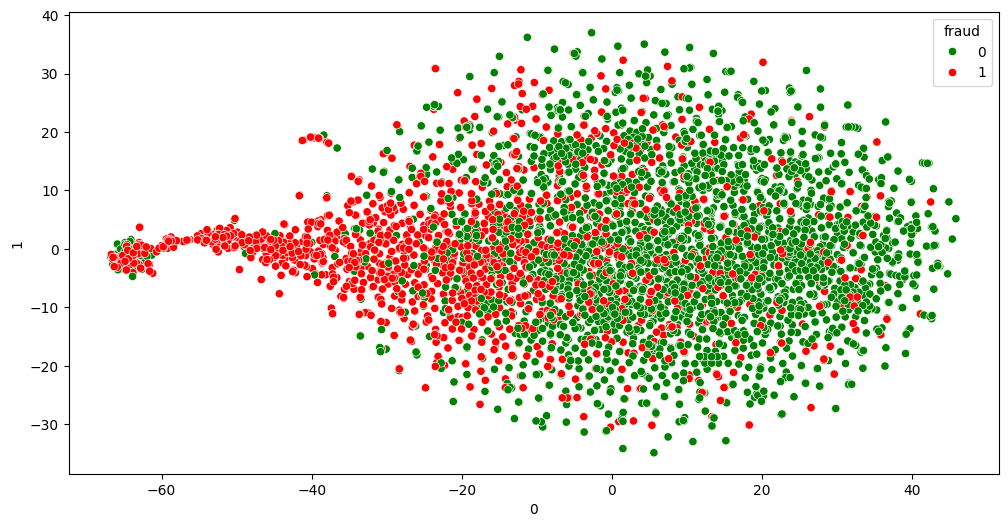

In [ ]:
from sklearn.manifold import TSNE

ge_tsne = TSNE(perplexity=12.0, metric='euclidean', random_state=1)
ge_tsne_np = ge_tsne.fit_transform(np.stack(ge_em_df["vector"].values))

ge_tsne_pd = pd.DataFrame(ge_tsne_np)
ge_tsne_pd["fraud"] = ge_em_df["fraud"].values
ge_tsne_pd["id"] = ge_em_df["customer"].values

fig, axes = plt.subplots(1, 1, figsize=((12,6)))
ax = sns.scatterplot(x=0, y=1,
                     hue="fraud", palette={0: "green", 1: "red"},
                     data=ge_tsne_pd)

# Spectral clustering <a name="spectral"></a>

Class `SpectralClustering` from `mercury.graph.ml` implements the **unsupervised [spectral clustering algorithm](https://www.sciencedirect.com/topics/computer-science/spectral-clustering)** to group nodes in a graph. This algorithm can work in two modes: "networkx" (running the algorithm locally, with a methodology similar to [scikit-learn's implementation](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.SpectralClustering.html) but expecting a graph object instead of a numpy array) or "spark" (using PySpark and graphframes).

In [ ]:
from mercury.graph.ml import SpectralClustering

In [ ]:
sc = SpectralClustering(n_clusters=4, mode="networkx")

print(sc)

Object of class SpectralClustering.

Initialization parameters: max_iterations=10, mode=networkx, n_clusters=4, random_state=0


As with `LouvainCommunities`, cluster assignments are available after fitting through the pandas dataframe `.labels_`, following the `scikit-learn` convention:

In [ ]:
sc.fit(g)

SpectralClustering(max_iterations=10, mode=networkx, n_clusters=4, random_state=0)

In [ ]:
sc_df = sc.labels_.rename(columns={"node_id": "id"})

sc_df

,id,cluster
0,C1000148617,3
1,M1053599405,3
2,M1400236507,3
3,M1741626453,0
4,M1823072687,3
...,...,...
4157,C99729647,3
4158,C998690782,0
4159,C998987490,3
4160,C999393223,2


Again, given the size and complexity of the graph, a viable option for visualizing the detected clusters is to color the embedding space created by [`GraphEmbedding`](#graph-embeddings) and reduced to two dimensions by using [TSNE](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html). This approach allows us to verify that the clusters created make sense, although it does not show information on the edges or the structure of the graph.

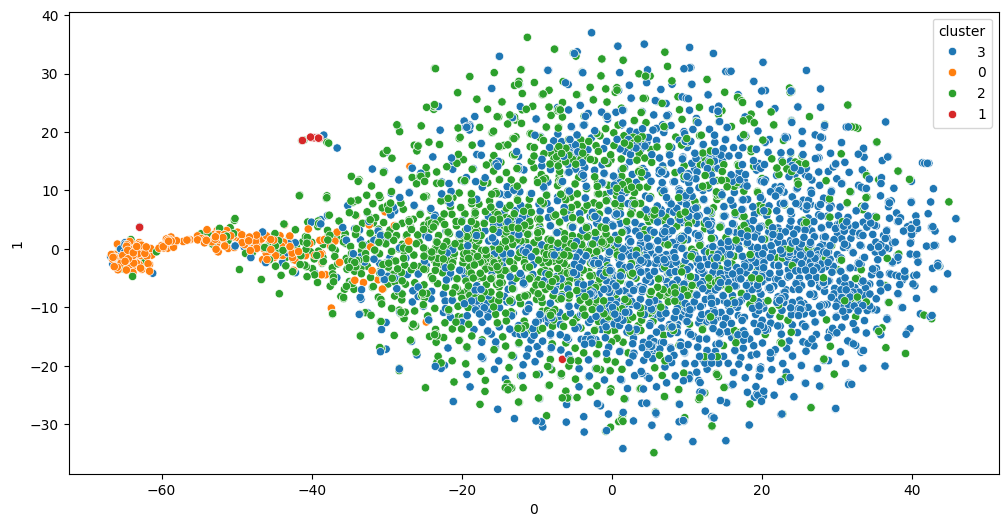

In [ ]:
sc_ge_tsne_df = ge_tsne_pd.merge(sc_df, on="id")
sc_ge_tsne_df["cluster"] = sc_ge_tsne_df["cluster"].astype(str)

fig, axes = plt.subplots(1, 1, figsize=((12,6)))
ax = sns.scatterplot(x=0, y=1, hue="cluster", data=sc_ge_tsne_df)

[**Modularity**](https://en.wikipedia.org/wiki/Modularity_(networks)) is a metric that measures the strength of the division of a graph into clusters:

In [ ]:
print(f"Modularity: {sc.modularity_}")

Modularity: 0.2966033614353375


Spectral clustering can also be performed using PySpark under the hood by simply passing `mode="spark"` to the constructor, which uses the `Graph` object's graphframe property.

# Transition matrix (Markov chains) <a name="transition"></a>

Class `Transition` of `mercury.graph.ml` can be used to obtain the **transition matrix** of a graph, which computes the distribution of probability of being in each of the nodes (or states) of a directed graph (or Markov process).

In [ ]:
from mercury.graph.ml import Transition

In [ ]:
tm = Transition().fit(g).to_pandas()

tm

,C1000148617,M1053599405,M1400236507,M1741626453,M1823072687,M1842530320,M1888755466,M1946091778,M209847108,M348934600,...,C995844287,C99594781,C996326258,C996804095,C997029022,C99729647,C998690782,C998987490,C999393223,C999723254
C1000148617,0.000000,0.035943,0.029184,0.003631,0.583136,0.021009,0.043517,0.002756,0.011818,0.138548,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
M1053599405,0.000235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000270,0.000266,0.00006,0.000159,0.0,0.000233,0.000000,0.000768,0.000404,0.000371
M1400236507,0.001489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.002381,0.0,0.002157,0.000000,0.000000,0.000000,0.000000
M1741626453,0.000182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006462,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000686,0.000000
M1823072687,0.000332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000195,0.000516,0.00012,0.000343,0.0,0.000330,0.000187,0.000448,0.000059,0.000243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C99729647,0.000000,0.028788,0.034113,0.000000,0.468406,0.006817,0.000000,0.041448,0.008097,0.250429,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
C998690782,0.000000,0.000000,0.000000,0.000000,0.144076,0.000000,0.000000,0.000000,0.007679,0.254239,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
C998987490,0.000000,0.094560,0.000000,0.000000,0.633667,0.000000,0.000000,0.001376,0.000000,0.063779,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
C999393223,0.000000,0.055548,0.000000,0.012276,0.092885,0.000000,0.000000,0.026377,0.011518,0.488176,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
